In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from IPython.display import display
from sklearn.metrics import silhouette_score
from scipy.stats.mstats import winsorize

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_theme(style="whitegrid", palette="Set2")  
BASE_PALETTE = sns.color_palette()

plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.2,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "grid.alpha": 0.4,
    "grid.linestyle": "--"
})

In [122]:
df = pd.read_csv('data/preprocessed_without_scaling.csv')
df.head(3)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Calories,sugar_g,serving_size_g,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,sodium_g,cholesterol_g,Carbs,Proteins,Fats,meal_name
0,35,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,1.50,4,2,24.87,3,1806.0,31.77,120.47,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,3,Legs,Lats,Dumbbell flyes,1.72994,0.28505,267.68,106.05,71.63,Grilled Vegan Lunch
1,23,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,1.90,4,2,23.48,3,1577.0,12.34,109.15,1.92,Bear Crawls,4,16,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,2,Chest,Lats,Lateral raises,0.69308,0.30061,214.32,85.41,56.97,Fried Vegetarian Lunch
2,33,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,1.88,3,1,21.15,2,1608.0,42.81,399.43,4.70,Dips,5,22,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,2,Arms,Grip Strength,Standing calf raises,2.14248,0.21542,246.04,98.11,65.48,Boiled Paleo Breakfast


In [123]:
df['diet_type'] = df['meal_name'].str.split().str[1]
input_features = [
    'Age',
    'Gender',
    'Weight (kg)',
    'Height (m)',
    'BMI',
    'Experience_Level',
    'Workout_Frequency (days/week)',
    'Daily meals frequency',
    'diet_type'
]


df_user_data = df[input_features]
df_user_data.head(3)

,Age,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days/week),Daily meals frequency,diet_type
0,35,Male,65.27,1.62,24.87,2,4,3,Vegan
1,23,Female,56.41,1.55,23.48,2,4,3,Vegetarian
2,33,Female,58.98,1.67,21.15,1,3,2,Paleo


Encoding of categorical features Genger and Diet type.

In [124]:
df_user_data = pd.get_dummies(df_user_data, columns=['Gender', 'diet_type'])
df_user_data.head(3)

,Age,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days/week),Daily meals frequency,Gender_Female,Gender_Male,diet_type_Balanced,diet_type_Keto,diet_type_Low-Carb,diet_type_Paleo,diet_type_Vegan,diet_type_Vegetarian
0,35,65.27,1.62,24.87,2,4,3,False,True,False,False,False,False,True,False
1,23,56.41,1.55,23.48,2,4,3,True,False,False,False,False,False,False,True
2,33,58.98,1.67,21.15,1,3,2,True,False,False,False,False,True,False,False


In [125]:
numeric_cols = ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 
                'Workout_Frequency (days/week)', 'Daily meals frequency']

mean_dict = {}
std_dict = {}

for col in numeric_cols:
    mean = df_user_data[col].mean()
    std = df_user_data[col].std()
    mean_dict[col] = mean
    std_dict[col] = std
    df_user_data[col + '_scaled'] = (df_user_data[col] - mean) / std

scaled_numeric_cols = [col + '_scaled' for col in numeric_cols]
categorical_scaled_cols = [c for c in df_user_data.columns if c not in numeric_cols and '_scaled' not in c]
final_features = scaled_numeric_cols + categorical_scaled_cols

X = df_user_data[final_features].values
df_user_data[final_features].head(3)

,Age_scaled,Weight (kg)_scaled,Height (m)_scaled,BMI_scaled,Workout_Frequency (days/week)_scaled,Daily meals frequency_scaled,Experience_Level,Gender_Female,Gender_Male,diet_type_Balanced,diet_type_Keto,diet_type_Low-Carb,diet_type_Paleo,diet_type_Vegan,diet_type_Vegetarian
0,-0.321350,-0.403548,-0.811881,-0.001794,0.743868,0.211608,2,False,True,False,False,False,False,True,False
1,-1.312164,-0.823087,-1.362754,-0.210191,0.743868,0.211608,2,True,False,False,False,False,False,False,True
2,-0.486485,-0.701392,-0.418400,-0.559517,-0.351407,-1.360622,1,True,False,False,False,False,True,False,False


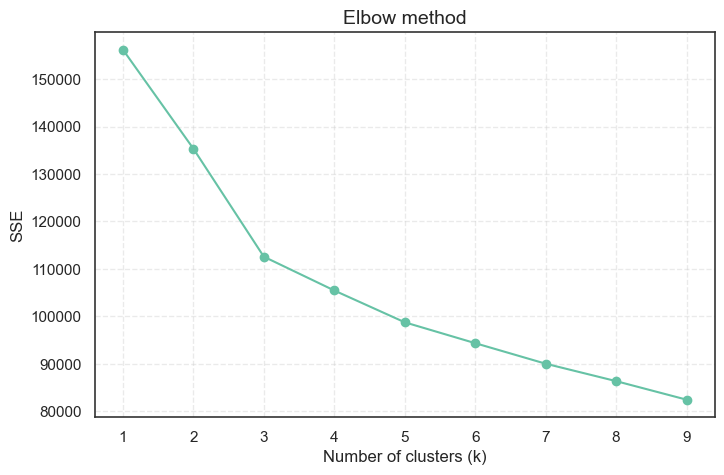

In [126]:
sse = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow method')
plt.show()

In [127]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
df_user_data['Cluster'] = kmeans.labels_

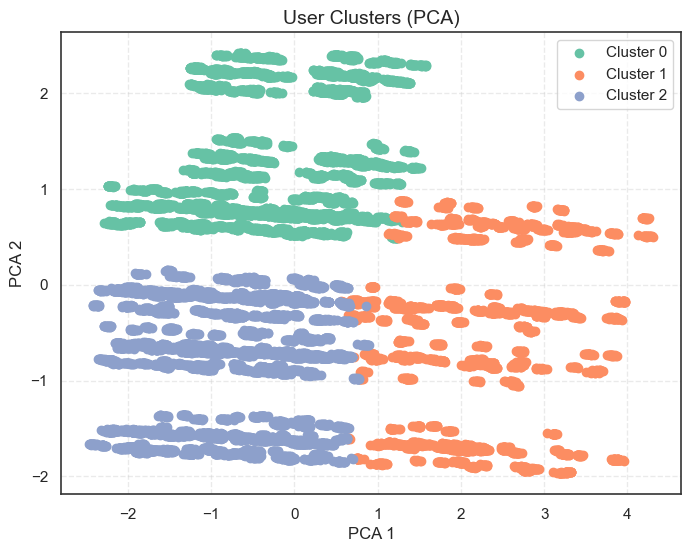

In [128]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for cluster in range(3):
    plt.scatter(
        X_pca[df_user_data['Cluster'] == cluster, 0],
        X_pca[df_user_data['Cluster'] == cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('User Clusters (PCA)')
plt.legend()
plt.show()

In [129]:
columns = [
    "Age",
    "Weight (kg)",
    "Height (m)",
    "BMI",
    "Experience_Level",
    "Workout_Frequency (days/week)",
    "Daily meals frequency",
    "Gender_Female",
    "Gender_Male",
    "diet_type_Balanced",
    "diet_type_Keto",
    "diet_type_Low-Carb",
    "diet_type_Paleo",
    "diet_type_Vegan",
    "diet_type_Vegetarian"
]

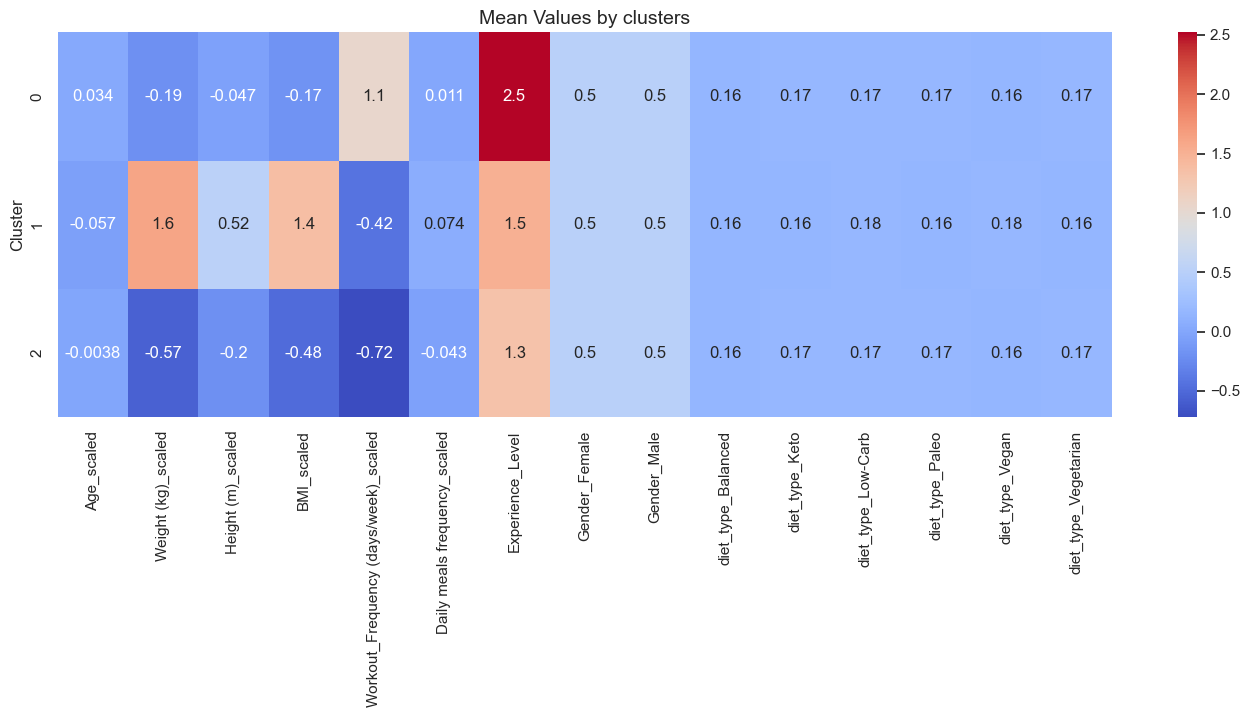

In [130]:
cluster_means = df_user_data.groupby('Cluster')[scaled_numeric_cols + categorical_scaled_cols].mean()

plt.figure(figsize=(17,5))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm')
plt.title('Mean Values by clusters')
plt.show()


In [131]:
score = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", score)

Silhouette Score: 0.16190537696506377


In [132]:
features_no_diet = [c for c in final_features if not c.startswith('diet_type') and not c.startswith('Gender')]
X2 = df_user_data[features_no_diet].values

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X2)
print(silhouette_score(X2, labels))

0.20336012075135518


Clustering was performed using only scaled numerical features. Categorical variables such as gender and diet type were excluded from the clustering process and used solely for post-cluster interpretation. This approach improved cluster separation and resulted in a higher silhouette score.

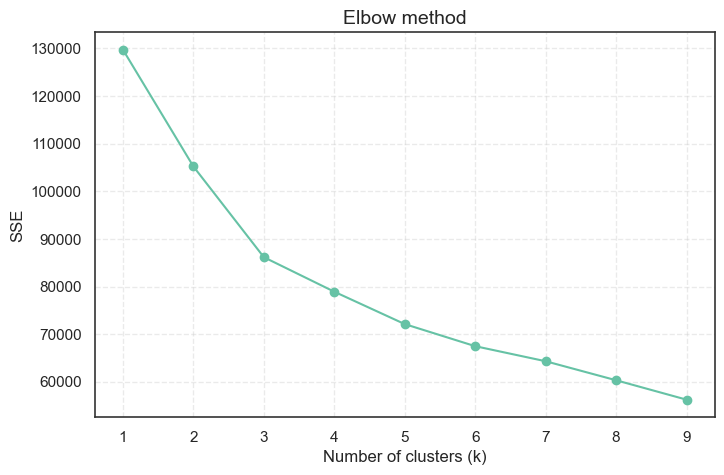

In [133]:
cluster_features = features_no_diet

sse = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X2)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow method')
plt.show()

In [134]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X2)
df_user_data['Cluster'] = kmeans.labels_

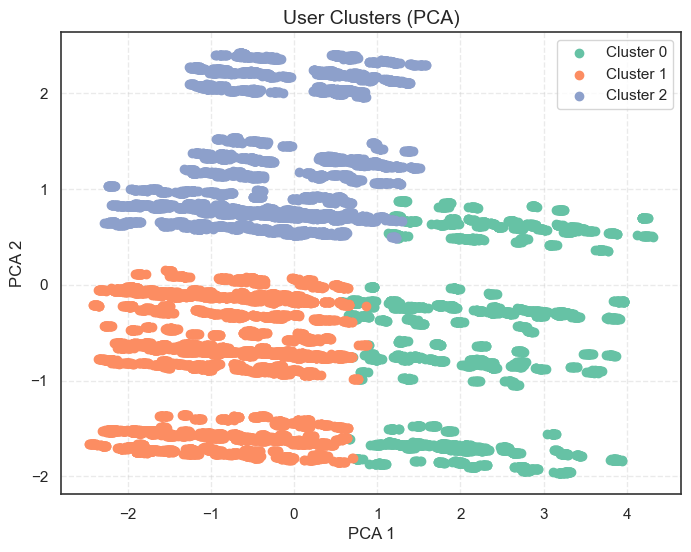

In [135]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X2)

plt.figure(figsize=(8,6))
for cluster in range(3):
    plt.scatter(
        X_pca[df_user_data['Cluster'] == cluster, 0],
        X_pca[df_user_data['Cluster'] == cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('User Clusters (PCA)')
plt.legend()
plt.show()

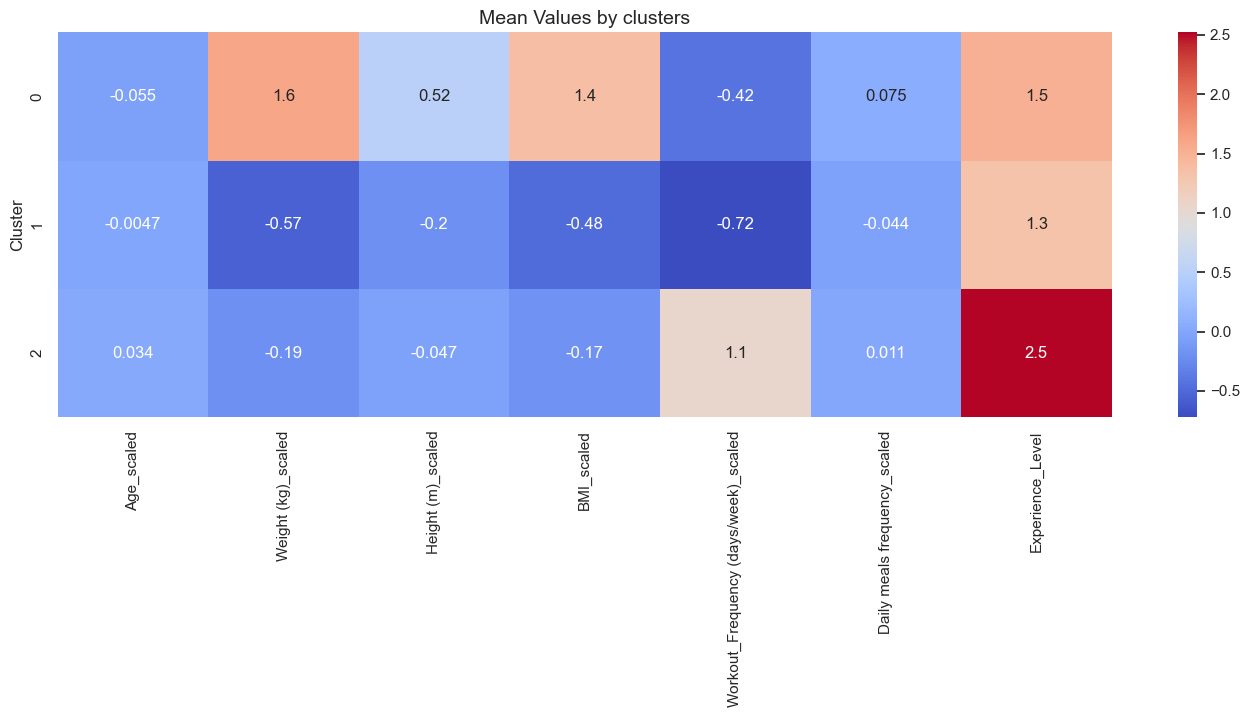

In [136]:
cluster_means = df_user_data.groupby('Cluster')[cluster_features].mean()

plt.figure(figsize=(17,5))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm')
plt.title('Mean Values by clusters')
plt.show()

In [137]:
cluster_means_unscaled = df_user_data.groupby('Cluster')[numeric_cols].mean()
display(cluster_means_unscaled)

,Age,Weight (kg),Height (m),BMI,Workout_Frequency (days/week),Daily meals frequency
Cluster,,,,,,
0,38.221282,107.753549,1.789074,34.040618,2.934103,2.912821
1,38.834922,61.790261,1.698168,21.655504,2.660784,2.837628
2,39.309537,69.691600,1.717162,23.764372,4.279634,2.872306


The clustering results reveal three distinct user groups primarily differentiated by BMI and workout frequency rather than age. This suggests that lifestyle and physical activity play a stronger role in user segmentation than demographic factors. Although the silhouette score is moderate, the clusters are stable and highly interpretable, which supports their practical relevance.

In [138]:
cluster_descriptions = {
    0: "Overweight & low activity",
    1: "Normal weight & low activity",
    2: "Active & fit"
}
df_user_data['cluster_description'] = df_user_data['Cluster'].map(cluster_descriptions)
df_user_data.head()

,Age,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days/week),Daily meals frequency,Gender_Female,Gender_Male,diet_type_Balanced,diet_type_Keto,diet_type_Low-Carb,diet_type_Paleo,diet_type_Vegan,diet_type_Vegetarian,Age_scaled,Weight (kg)_scaled,Height (m)_scaled,BMI_scaled,Workout_Frequency (days/week)_scaled,Daily meals frequency_scaled,Cluster,cluster_description
0,35,65.27,1.62,24.87,2,4,3,False,True,False,False,False,False,True,False,-0.321350,-0.403548,-0.811881,-0.001794,0.743868,0.211608,2,Active & fit
1,23,56.41,1.55,23.48,2,4,3,True,False,False,False,False,False,False,True,-1.312164,-0.823087,-1.362754,-0.210191,0.743868,0.211608,2,Active & fit
2,33,58.98,1.67,21.15,1,3,2,True,False,False,False,False,True,False,False,-0.486485,-0.701392,-0.418400,-0.559517,-0.351407,-1.360622,1,Normal weight & low activity
3,39,93.78,1.70,32.45,2,4,3,True,False,False,False,False,True,False,False,0.008922,0.946458,-0.182312,1.134640,0.743868,0.211608,0,Overweight & low activity
4,45,52.42,1.88,14.83,2,4,3,False,True,False,False,False,False,True,False,0.504329,-1.012022,1.234219,-1.507045,0.743868,0.211608,2,Active & fit


In [139]:
new_user = pd.DataFrame([{
    'Age': 38,
    'Weight (kg)': 100,
    'Height (m)': 1.70,
    'BMI': 34.6,
    'Workout_Frequency (days/week)': 3,
    'Daily meals frequency': 2,
    'Gender': 'Female',
    'diet_type': 'Low-Carb'
}])

new_user_encoded = pd.get_dummies(new_user, columns=['Gender', 'diet_type'])

# Добавляем отсутствующие колонки с нулями
for col in categorical_scaled_cols:
    if col not in new_user_encoded.columns:
        new_user_encoded[col] = 0

# Стандартизируем числовые признаки
for col in numeric_cols:
    new_user_encoded[col + '_scaled'] = (new_user_encoded[col] - mean_dict[col]) / std_dict[col]

X_new = new_user_encoded[cluster_features].values
cluster_new_user = kmeans.predict(X_new)
print("New user's cluster id:", cluster_new_user[0])


New user's cluster id: 0


Clusterization evaluation

In [140]:
scores = []
for seed in range(10):
    kmeans = KMeans(n_clusters=3, random_state=seed)
    labels = kmeans.fit_predict(X2)
    scores.append(silhouette_score(X2, labels))

print(scores)
print("Mean:", np.mean(scores))
print("Std:", np.std(scores))

[0.2033800081376661, 0.2033800081376661, 0.20336919256023045, 0.20336012075135518, 0.2033725408281078, 0.20338611404793702, 0.2033800081376661, 0.20337319523972489, 0.20336712134933244, 0.20337502318483902]
Mean: 0.20337433323745252
Std: 7.216768141506653e-06


In [141]:
df_user_data['Cluster'].value_counts(normalize=True)

Cluster
1    0.428744
2    0.374514
0    0.196741
Name: proportion, dtype: float64

In [142]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3)
labels_agg = agg.fit_predict(X2)

print("Agglomerative silhouette:", silhouette_score(X2, labels_agg))

Agglomerative silhouette: 0.1739739804053277


In [143]:
df.loc[df_user_data.index, 'Cluster'] = kmeans.labels_
df['cluster_description'] = df['Cluster'].map(cluster_descriptions)

df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Calories,sugar_g,serving_size_g,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,sodium_g,cholesterol_g,Carbs,Proteins,Fats,meal_name,diet_type,Cluster,cluster_description
0,35,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,1.50,4,2,24.87,3,1806.0,31.77,120.47,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,3,Legs,Lats,Dumbbell flyes,1.72994,0.28505,267.68,106.05,71.63,Grilled Vegan Lunch,Vegan,1.0,Normal weight & low activity
1,23,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,1.90,4,2,23.48,3,1577.0,12.34,109.15,1.92,Bear Crawls,4,16,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,2,Chest,Lats,Lateral raises,0.69308,0.30061,214.32,85.41,56.97,Fried Vegetarian Lunch,Vegetarian,1.0,Normal weight & low activity
2,33,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,1.88,3,1,21.15,2,1608.0,42.81,399.43,4.70,Dips,5,22,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,2,Arms,Grip Strength,Standing calf raises,2.14248,0.21542,246.04,98.11,65.48,Boiled Paleo Breakfast,Paleo,0.0,Overweight & low activity
3,39,Female,93.78,1.70,191.21,155.10,50.07,1.10,1450.79,HIIT,2.50,4,2,32.45,3,2657.0,9.34,314.31,4.85,Mountain Climbers,4,17,Improves coordination and cardiovascular health,351.65,"Biceps, Forearms",Parallel Bars or Chair,3,Shoulders,Upper,Incline dumbbell flyes,0.12320,0.00970,203.22,80.84,54.56,Fried Paleo Lunch,Paleo,2.0,Active & fit
4,45,Male,52.42,1.88,193.58,152.88,70.84,1.08,1166.40,Strength,2.91,4,2,14.83,3,1470.0,23.78,99.22,3.07,Bicep Curls,5,15,Targets obliques and improves core rotation,329.36,"Chest, Triceps",Wall,3,Abs,Wrist Flexors,Military press,1.93511,0.11689,332.79,133.05,88.43,Baked Vegan Breakfast,Vegan,1.0,Normal weight & low activity


In [144]:
df.to_csv('data/dataset_with_clusters.csv', index=False)